In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna

from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_happy_and_teddy.csv')

Mounted at /content/drive


In [3]:
# Define feature columns and target column (using normalized features)
features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']
target = 'z_spec'


In [4]:
# Handle missing values
df = df.dropna(subset=features + [target])


In [5]:
X = df[features]
y = df[target]



In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'GradientBoosting'])
    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
    else:
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = GradientBoostingRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [8]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-08-12 21:28:44,478] A new study created in memory with name: no-name-cc166797-bb6e-48ba-ba1c-1fa6397edc5f
<ipython-input-7-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2024-08-12 21:54:26,515] Trial 0 finished with value: 0.005625316938913901 and parameters: {'model_type': 'GradientBoosting', 'learning_rate': 0.12792995953708425, 'n_estimators': 185, 'max_depth': 18}. Best is trial 0 with value: 0.005625316938913901.
<ipython-input-7-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2024-

In [9]:
# Get the best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')


Best hyperparameters: {'model_type': 'RandomForest', 'n_estimators': 254, 'max_depth': 49}


In [10]:
# Train and evaluate the best model
if best_params['model_type'] == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
else:
    best_model = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = best_model.score(X_train, y_train)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = best_model.score(X_test, y_test)

print(f'Training MSE: {mse_train}')
print(f'Training RMSE: {rmse_train}')
print(f'Training R²: {r2_train}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

Training MSE: 0.0007466716857455062
Training RMSE: 0.02732529388214345
Training R²: 0.9763207747786228
Test MSE: 0.005172456300742832
Test RMSE: 0.07191979074457067
Test R²: 0.8343980086567057


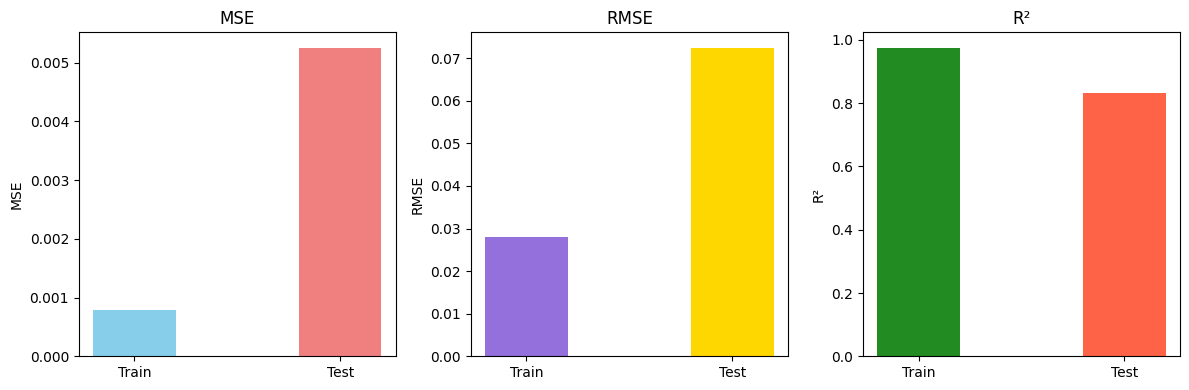

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# New performance metrics for combined dataset
training_scores_combined = [0.0007820074568386909, 0.027964396235904878, 0.9752001702370817]
test_scores_combined = [0.005251404062778026, 0.07246657203689179, 0.8318704074852377]

# Set the figure size
plt.figure(figsize=(12, 4))

# Plotting MSE
plt.subplot(1, 3, 1)
bar_width = 0.4
index = np.arange(2)
plt.bar(index, [training_scores_combined[0], test_scores_combined[0]], bar_width, color=['skyblue', 'lightcoral'])
plt.xticks(index, ['Train', 'Test'])
plt.title('MSE')
plt.ylabel('MSE')

# Plotting RMSE
plt.subplot(1, 3, 2)
plt.bar(index, [training_scores_combined[1], test_scores_combined[1]], bar_width, color=['mediumpurple', 'gold'])
plt.xticks(index, ['Train', 'Test'])
plt.title('RMSE')
plt.ylabel('RMSE')

# Plotting R²
plt.subplot(1, 3, 3)
plt.bar(index, [training_scores_combined[2], test_scores_combined[2]], bar_width, color=['forestgreen', 'tomato'])
plt.xticks(index, ['Train', 'Test'])
plt.title('R²')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


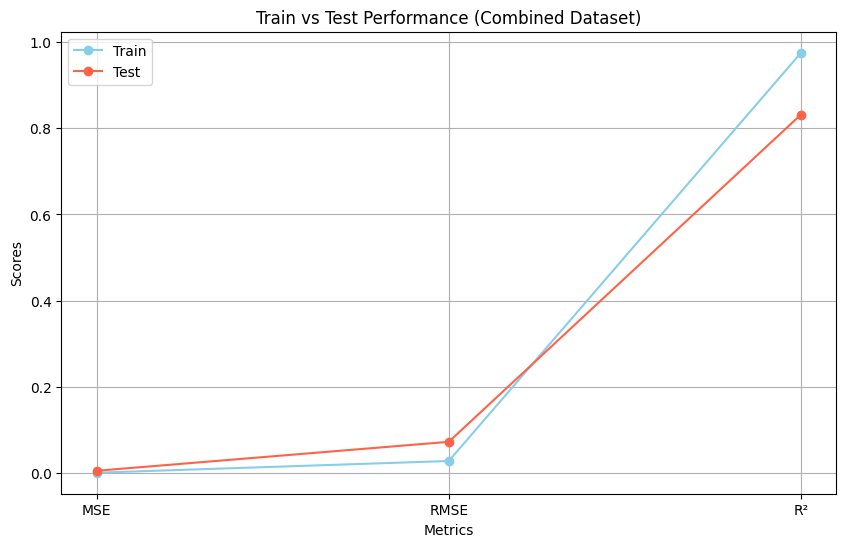

In [12]:
# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
train_scores_combined = [0.0007820074568386909, 0.027964396235904878, 0.9752001702370817]
test_scores_combined = [0.005251404062778026, 0.07246657203689179, 0.8318704074852377]

plt.figure(figsize=(10, 6))

plt.plot(metrics, train_scores_combined, marker='o', label='Train', color='skyblue')
plt.plot(metrics, test_scores_combined, marker='o', label='Test', color='tomato')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Train vs Test Performance (Combined Dataset)')
plt.legend()
plt.grid(True)
plt.show()


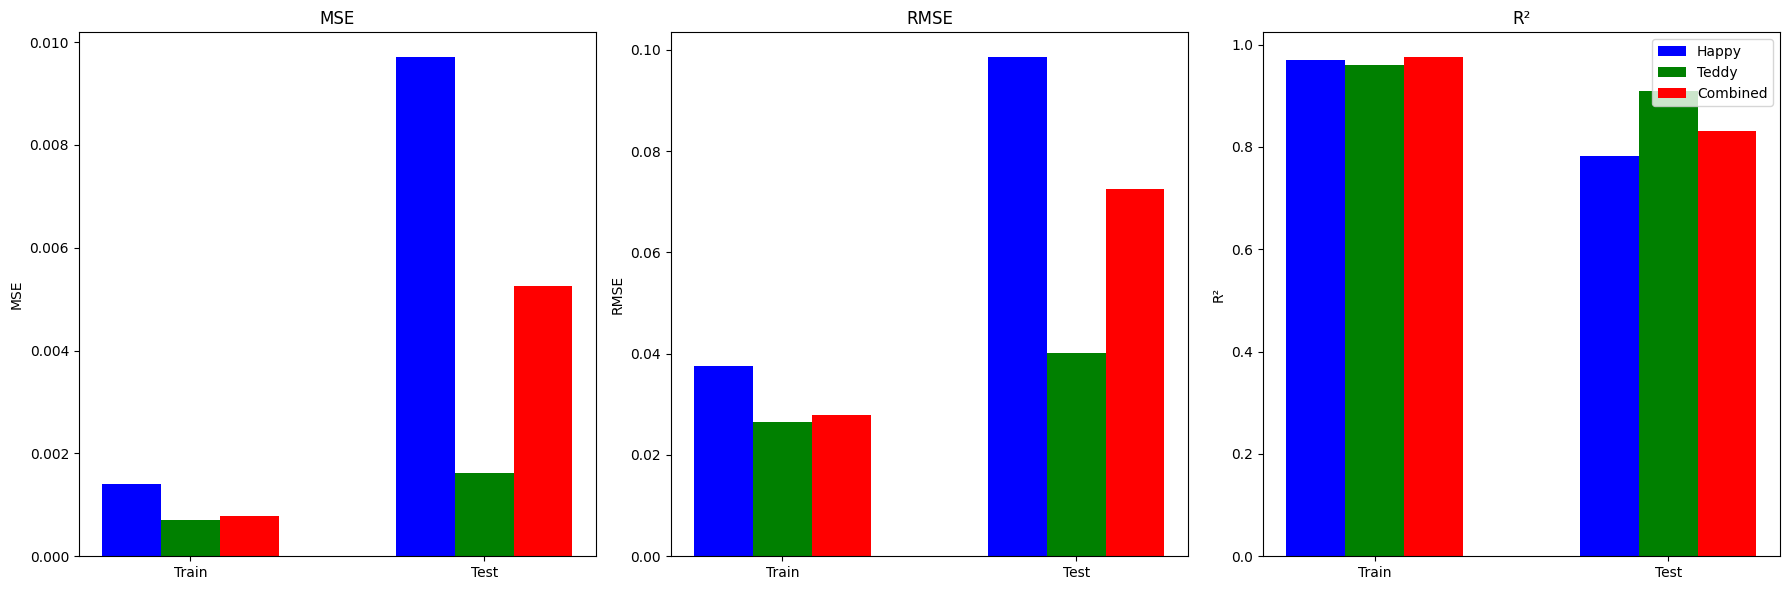

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for Happy, Teddy, and Combined datasets
happy_metrics = [0.0014137342183336333, 0.03759965715712888, 0.9689838861906248, 0.009705949689442826, 0.09851877835947229, 0.781844647208765]
teddy_metrics = [0.0007063669932992196, 0.026577565601447015, 0.960427662321778, 0.0016141123620710361, 0.0401760172499843, 0.9093868114563499]
combined_metrics = [0.0007820074568386909, 0.027964396235904878, 0.9752001702370817, 0.005251404062778026, 0.07246657203689179, 0.8318704074852377]

# Set the figure size
plt.figure(figsize=(18, 6))

# Plotting MSE
plt.subplot(1, 3, 1)
bar_width = 0.2
index = np.arange(2)
plt.bar(index, [happy_metrics[0], happy_metrics[3]], bar_width, label='Happy', color='blue')
plt.bar(index + bar_width, [teddy_metrics[0], teddy_metrics[3]], bar_width, label='Teddy', color='green')
plt.bar(index + 2 * bar_width, [combined_metrics[0], combined_metrics[3]], bar_width, label='Combined', color='red')
plt.xticks(index + bar_width, ['Train', 'Test'])
plt.title('MSE')
plt.ylabel('MSE')

# Plotting RMSE
plt.subplot(1, 3, 2)
plt.bar(index, [happy_metrics[1], happy_metrics[4]], bar_width, label='Happy', color='blue')
plt.bar(index + bar_width, [teddy_metrics[1], teddy_metrics[4]], bar_width, label='Teddy', color='green')
plt.bar(index + 2 * bar_width, [combined_metrics[1], combined_metrics[4]], bar_width, label='Combined', color='red')
plt.xticks(index + bar_width, ['Train', 'Test'])
plt.title('RMSE')
plt.ylabel('RMSE')

# Plotting R²
plt.subplot(1, 3, 3)
plt.bar(index, [happy_metrics[2], happy_metrics[5]], bar_width, label='Happy', color='blue')
plt.bar(index + bar_width, [teddy_metrics[2], teddy_metrics[5]], bar_width, label='Teddy', color='green')
plt.bar(index + 2 * bar_width, [combined_metrics[2], combined_metrics[5]], bar_width, label='Combined', color='red')
plt.xticks(index + bar_width, ['Train', 'Test'])
plt.title('R²')
plt.ylabel('R²')

plt.legend()
plt.tight_layout()
plt.show()


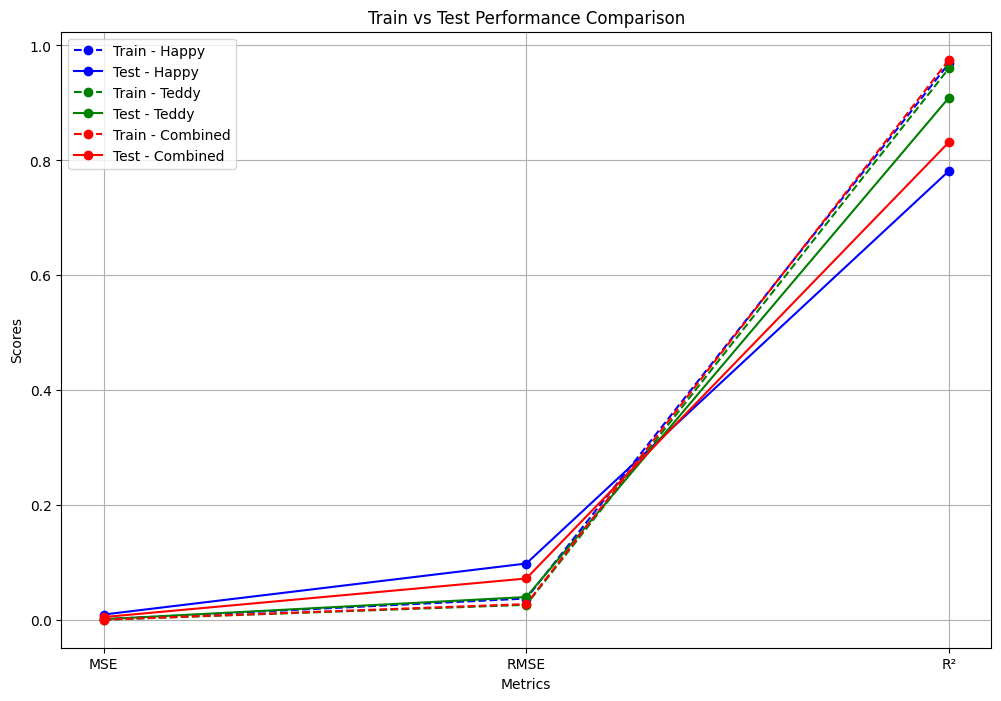

In [14]:
# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
train_scores_happy = [0.0014137342183336333, 0.03759965715712888, 0.9689838861906248]
test_scores_happy = [0.009705949689442826, 0.09851877835947229, 0.781844647208765]
train_scores_teddy = [0.0007063669932992196, 0.026577565601447015, 0.960427662321778]
test_scores_teddy = [0.0016141123620710361, 0.0401760172499843, 0.9093868114563499]
train_scores_combined = [0.0007820074568386909, 0.027964396235904878, 0.9752001702370817]
test_scores_combined = [0.005251404062778026, 0.07246657203689179, 0.8318704074852377]

plt.figure(figsize=(12, 8))

# Plot Happy dataset
plt.plot(metrics, train_scores_happy, marker='o', label='Train - Happy', color='blue', linestyle='dashed')
plt.plot(metrics, test_scores_happy, marker='o', label='Test - Happy', color='blue')

# Plot Teddy dataset
plt.plot(metrics, train_scores_teddy, marker='o', label='Train - Teddy', color='green', linestyle='dashed')
plt.plot(metrics, test_scores_teddy, marker='o', label='Test - Teddy', color='green')

# Plot Combined dataset
plt.plot(metrics, train_scores_combined, marker='o', label='Train - Combined', color='red', linestyle='dashed')
plt.plot(metrics, test_scores_combined, marker='o', label='Test - Combined', color='red')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Train vs Test Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()
